In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import numpy as np
from scipy.stats import spearmanr

from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi

In [3]:
def filter_out_nan(origin):
    new_list = origin
    new_list = [x for x in new_list if str(x) != 'nan']
    return new_list

def palette_builder(cre_line, colour):
    palette = {}
    colours = filter_out_nan(colour)
    index = 0
    for cre in cre_line:
        palette[cre] = colours[index]
        index = index + 1
    return palette

In [13]:
# load all data from csvs stored in the repo

#csv file of all electrophysiology, morphology features, ion conductance, nm_id
all_features = pd.read_csv("all_features.csv", index_col=0)
#csv file of all electrophysiology, morphology features, ion conductance, nm_id, including cell type
all_features_cell_type = pd.read_csv("all_features_cell_type.csv", index_col=0)

abs_all_features = pd.read_csv("abs_all_features.csv", index_col=0)

abs_all_features_cell_type = pd.read_csv("abs_all_features_cell_type.csv", index_col=0)


#transcriptomic gene expression data by cell type
transcriptome_df = pd.read_csv("transcriptome_df.csv", index_col=0)
#transcriptomic gene expressions data with all separate cortical layers
new_transcriptome_df = pd.read_csv('sep_layer_df.csv', index_col=0)
#transcriptomic gene expression data with only cre-line
new_label_df = pd.read_csv("new_label_transcriptome_df.csv", index_col=0)

#relavtive ion conductance data for only cre-lines
cre_parameter_df = pd.read_csv("cre_parameter_df.csv", index_col=0)
#absolute ion conductance data for cell types
abs_parameter_df = pd.read_csv("abs_parameter_df.csv", index_col=0)
#relative conductance data for cell types
sep_layer_cre_parameter_df = pd.read_csv('sep_layer_cre_parameter_df.csv', index_col=0)

#csv for entrenz symbol and associated gene
entrenz_symbol_s = pd.read_csv("entrenz_symbol_s.csv", index_col=0, names = ['entrez_id', 'gene_symbol'])

#csv file about channel genes and their associated ion channels
ion_channel_genes = pd.read_csv("targets_and_families.csv", index_col=0)

#Spearman Correlation ranks at cre-line level
f = open("new_spearman_corr_ranks.json","r")
data = json.load(f)
spearman_corr_ranks = data
f.close()

#Spearman Correlation ranks for cell types and relative conductance
f = open("new_sep_spearman_corr_ranks.json","r")
data = json.load(f)
sep_spearman_corr_ranks = data
f.close()

#Spearman Correlation ranks for cell types and absolute conductance
#f = open("abs_spearman_corr_ranks.json","r")
#data = json.load(f)
#abs_spearman_corr_ranks = data
#f.close()

#cre line basic metadata
cre_line_metadata = pd.read_csv("data/cre_line_info.csv", index_col=0)




sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#Parameter names
org = pd.read_csv("org.csv", index_col=0)
parameters = list(org['parameters'])

#Parameter names for absolute conductance
abs_parameters = list('abs_' + org['parameters'])

#6 Parameters shared by all neuronal models
shared_parameters = filter_out_nan(list(org['shared']))

#Dictionary of the related genes to the 6 parameters
related_RNA = {}
for para in shared_parameters:
    related_RNA[para] = filter_out_nan(list(org[para]))

abs_related_RNA = {}
for para in shared_parameters:
    abs_related_RNA['abs_' + para] = filter_out_nan(list(org[para]))
abs_related_RNA

#List of gene channels that are voltage gated
ion_channel_genes = ion_channel_genes[ion_channel_genes['MGI symbol'].notnull()]
gene_channel = ion_channel_genes.loc["vgic"]
gene_channel = gene_channel['MGI symbol'].values
gene_channel = list(gene_channel)

gene_channel_vgic = ion_channel_genes.loc["vgic"]
gene_channel_vgic

exclude = []
for gene in list(gene_channel_vgic['Mouse Entrez Gene']):
    if int(gene) in list(transcriptome_df.index):
        if sum(list(transcriptome_df.loc[int(gene)]))/len(list(transcriptome_df.loc[int(gene)])) < .1:
            exclude.append(gene)
for excluded_gene in exclude:
    gene_channel_vgic_filtered = gene_channel_vgic[gene_channel_vgic['Mouse Entrez Gene'] != excluded_gene]
                
gene_channel_vgic_filtered

#Set-up for palette for cell types based on Cre-line
cre_color_inc_4 = filter_out_nan(list(org['cre_line']))
cre_line_palette_inc_4 = palette_builder(cre_color_inc_4, list(org['colour']))
    
shortened_color = filter_out_nan(list(org['short']))
shortened_palette = palette_builder(shortened_color, list(org['colour']))

#import new cpm count from new dataset
new_cpm = pd.read_csv("norm_raw_counts_filtered.csv", index_col=0)

In [41]:
all_features_cell_type_Cux = all_features_cell_type[all_features_cell_type['cell_type'].str.startswith('Cux')]
all_features_cell_type_Cux['gbar_Kv3_1']

228          NaN
232     0.000007
374     0.148890
563     0.321439
623     0.000100
665     0.078343
850     0.132701
991     0.343501
1023    0.185299
1882    0.140341
Name: gbar_Kv3_1, dtype: float64

In [22]:
new_cpm_Cux = new_cpm.filter(regex='Cux2.*positive', axis=1)

In [25]:
new_cpm_Cux.loc['Kcnc1']

Cux2_tdTpositive_cell_1      2.625628
Cux2_tdTpositive_cell_2      4.526880
Cux2_tdTpositive_cell_3      4.151761
Cux2_tdTpositive_cell_4      0.614982
Cux2_tdTpositive_cell_5      2.983566
Cux2_tdTpositive_cell_6      5.297291
Cux2_tdTpositive_cell_7      2.205336
Cux2_tdTpositive_cell_8      1.890877
Cux2_tdTpositive_cell_9      5.158404
Cux2_tdTpositive_cell_10     0.243985
Cux2_tdTpositive_cell_11     0.846921
Cux2_tdTpositive_cell_12     0.000000
Cux2_tdTpositive_cell_13     2.413722
Cux2_tdTpositive_cell_14     0.000000
Cux2_tdTpositive_cell_15     5.704344
Cux2_tdTpositive_cell_16     0.288285
Cux2_tdTpositive_cell_17     0.000000
Cux2_tdTpositive_cell_18     0.263078
Cux2_tdTpositive_cell_19     5.939719
Cux2_tdTpositive_cell_20     0.851380
Cux2_tdTpositive_cell_21     0.484376
Cux2_tdTpositive_cell_22     0.410690
Cux2_tdTpositive_cell_23     7.331763
Cux2_tdTpositive_cell_24     2.343846
Cux2_tdTpositive_cell_25     4.702086
Cux2_tdTpositive_cell_26     0.425518
Cux2_tdTposi

In [26]:
#calculate the standard deviation and sem
def cal_std_sem(index_name):
    index_name = list(org['parameters'])
    index_name.append('cell_type')
    stdcal = all_features_cell_type[all_features_cell_type['gbar_Ih'].notna()]
    stdcal = stdcal[stdcal['cell_type'] != 'False']
    stdcal = stdcal[index_name]
    std = stdcal.groupby('cell_type').std()
    sem = stdcal.groupby('cell_type').sem()
    std.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                         "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                     inplace = True) 
    sem.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                         "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                     inplace = True) 
    return sem, std

#set sem and std to the values for standard deviation and sem for relative
sem, std = cal_std_sem(parameters)

#set sem and std to the values for standard deviation and sem for absolute
abs_sem, abs_std = cal_std_sem(abs_parameters)

In [27]:
def create_cre_conductance(parameter_type, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inc_4 , : ]
    return cre_conductance_filtered

def create_gene_spec_filtered(gene_symbol):
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_inc_4])
    return gene_spec_filtered, gene_id

def rename_graph_spec(graph_spec):
    renaming_index = palette_builder(cre_color_inc_4, shortened_color)
    graph_spec.rename(index = renaming_index, 
                                 inplace = True)

In [28]:
def create_graph_spec(parameter_type, gene_symbol, df):
    cre_conductance_filtered = create_cre_conductance(parameter_type, df)
   
    gene_spec_filtered, gene_id = create_gene_spec_filtered(gene_symbol)
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    
    rename_graph_spec(graph_spec)
    
    return graph_spec

In [75]:
#Graphing scatterplot of conductance and transcriptomics
def predict(parameter_type, gene_symbol, df, xlabel, ylabel, 
                                show_errorbars = True,
                                show_legend = True, 
                                show_best_line = True, 
                                poly_deg = 2 # degree of polynomial for fit
                               ):
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 

    # get standard errors
    std_cre = sem.loc[cre_color_inc_4,:]
    errors = std_cre[parameter_type]
    inv_errors = 1/errors
    
    # set up plot parameters
#     plt.figure(figsize=(7, 7))   
#     mpl.rcParams['pdf.fonttype'] = 42
#     mpl.rcParams['ps.fonttype'] = 42
#     plt.rcParams['svg.fonttype'] = 'none'
    
    graph_spec.sort_values(by=[gene_id], inplace = True)
    mini = graph_spec.iloc[0, :][gene_id]
    # mini = 0
    maxi = graph_spec.iloc[14, :][gene_id]
    
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 
    
    # best fit line
    if(show_best_line):
        #z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=poly_deg, w=inv_errors)
        z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=poly_deg)
        #z = np.polyfit(x= graph_spec[gene_id], y=np.log(graph_spec[parameter_type]), deg=1)
        p = np.poly1d(z)
        xp = np.linspace(mini, maxi, 100)
        #_ = plt.plot(xp, np.exp(p(xp)), '-', zorder=1)
        _ = plt.plot(xp, p(xp), '-', zorder=1)
        
        formula = '' + parameter_type + ' ~ ' + gene_symbol +  ' + 1'
        print(formula)
        
        graph_spec_new = graph_spec.copy()
        graph_spec_new.index = range(15)

        graph_spec_new.rename(columns={gene_id: gene_symbol}, inplace= True)

        gamma_model = smf.glm(formula = formula, data = graph_spec_new, family=sm.families.Gamma())
        gamma_results = gamma_model.fit()
        xp_df = pd.DataFrame(data = {gene_symbol : xp})
        predicted_vals = gamma_results.predict(xp_df)
        _ = plt.plot(xp, predicted_vals, '-', zorder=1)
#         predicted_vals = gamma_results.predict(graph_spec_new[gene_symbol])
#         _ = plt.plot(graph_spec_new[gene_symbol], predicted_vals, '.', zorder=1)
        predicted = gamma_results.predict(new_cpm_Cux.loc['Kcnc1'])

        
    # plot data points
    ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=shortened_color, data=graph_spec, s = 100, palette=shortened_palette, zorder=3)
    
    # legend handling
    if (show_legend):
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types", fontsize=15)
    else:
        ax.get_legend().remove()
    
    
#     plt.rcParams['font.family'] = 'sans-serif'
#     plt.rcParams['font.sans-serif'] = ['Tahoma']
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

#     ax.xaxis.label.set_size(12)
#     ax.yaxis.label.set_size(12)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    if (show_errorbars):
        # Find the x,y coordinates for each point for errorbar plotting
        x_coords = []
        y_coords = []
        for point_pair in ax.collections:
            for x, y in point_pair.get_offsets():
                x_coords.append(x)
                y_coords.append(y)

        ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', alpha=.5 ,zorder=2)
    return ax, predicted
#     return(plt)


gbar_Kv3_1 ~ Kcnc1 + 1


C:\Users\Allose\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:302: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


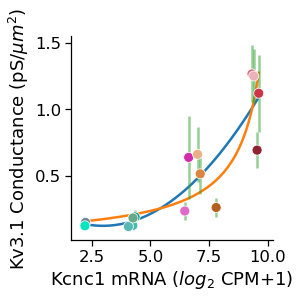

In [77]:
import matplotlib.gridspec as gridspec
# Initialize the grid with 3 rows and 3 columns
ncols = 3
nrows = 3
fig = plt.figure(figsize = (13, 14))

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.45, hspace=0.45)


ax1 = fig.add_subplot(grid[0, 0])
ax1, predicted = predict('gbar_Kv3_1', 'Kcnc1', sep_layer_cre_parameter_df, 'Kcnc1 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)


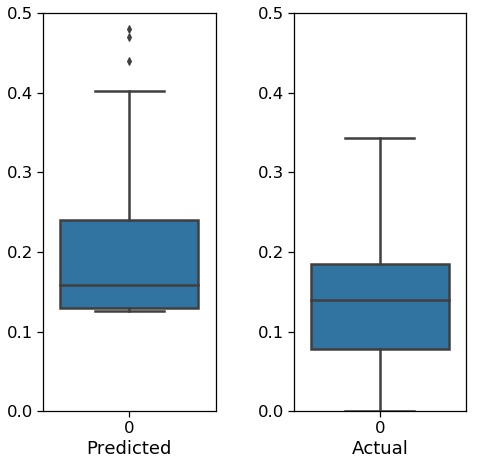

In [108]:
ncols = 2
nrows = 1
fig = plt.figure(figsize = (7, 7))

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.45, hspace=0.45)
actual = list(all_features_cell_type_Cux['gbar_Kv3_1'].dropna())


ax1 = fig.add_subplot(grid[0, 0])
ax1 = sns.boxplot(data = predicted).set(xlabel='Predicted', ylim=(0,0.5))
ax2 = fig.add_subplot(grid[0, 1])
ax2 = sns.boxplot(data = actual).set(xlabel='Actual', ylim=(0,0.5))